In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, ConfusionMatrixDisplay
import optuna
from sklearn.pipeline import make_pipeline, Pipeline
import xgboost as xgb  
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.decomposition import PCA

C:\Users\aksha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
competition_data = pd.read_csv('Multi-Class Prediction of Cirrhosis Outcome/train.csv').drop(columns=['id'],axis=1)
original_data = pd.read_csv('Cirrhosis Patient Survival Prediction/cirrhosis.csv')[competition_data.columns] 

test_data = pd.read_csv('Multi-Class Prediction of Cirrhosis Outcome/test.csv')
test_IDs = test_data.id

train_data = pd.concat(objs=[competition_data, original_data]).reset_index(drop=True)

In [4]:
print('train_data rows: ',train_data.shape[0])
print('train_data columns: ',train_data.shape[1])
print()
print('test_transaction rows: ',test_data.shape[0])
print('test_transaction columns: ',test_data.shape[1])

train_data rows:  8323
train_data columns:  19

test_transaction rows:  5271
test_transaction columns:  19


In [5]:
LABEL = "Status"
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_data.columns if x not in CAT_FEATS and x != LABEL]
ORG_FEATS = train_data.drop(LABEL, axis=1).columns.tolist()

### Let's check target class imbalance:

Count of each Status:
Status
C     5197
D     2826
CL     300
Name: count, dtype: int64



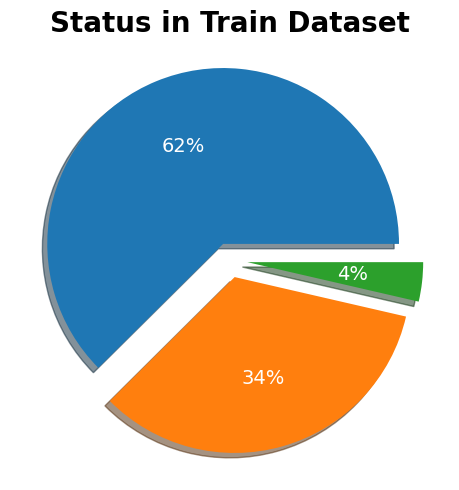

In [6]:
status_counts = train_data['Status'].value_counts()
print("Count of each Status:")
print(status_counts)
print()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.pie(
    train_data['Status'].value_counts(), 
    shadow=True, 
    explode=[.1 for i in range(train_data['Status'].nunique())],  # Adjust the explode based on the number of unique values
    autopct='%1.f%%',
    textprops={'size': 14, 'color': 'white'}
)

ax.set_title('Status in Train Dataset', fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

In the piechart above, it can be seen how **few CL occurnces** there are. 

To solve this imbalance we used **SMOTE**

While **SMOTE increased the overall accuracy** of most models, **the submission score was the total opposite**!

And so I do not recommend using SMOTE and I have **removed** it from the notebook.

# Medical defenition of the features 

Let us take a look at what each feature indicates:

* **N_Days:** Number of days betwqeen registration and the earlier of death, transplantation, or study analysis time in July 1986
* **Drug:** Type of drug administered to the patient, with options such as D-penicillamine or Placebo.
* **Age:** Age of the patient, indicating the chronological age at the time of data collection.
* **Sex:** Gender of the patient, with "F" representing females.
* **Ascites:** Presence or absence of ascites, a medical condition characterized by fluid accumulation in the abdomen.
* **Hepatomegaly:** Presence or absence of hepatomegaly, an enlargement of the liver.
* **Spiders:** Presence or absence of spider angiomas, visible blood vessels in a spider-like pattern on the skin.
* **Edema:** Presence or absence of edema, which is swelling caused by the accumulation of excess fluid in body tissues.
* **Bilirubin:** Bilirubin levels in the blood, an indicator of liver function.
* **Cholesterol:**  Cholesterol levels in the blood, a measure of lipid metabolism.
* **Albumin:** Albumin levels in the blood, an important protein produced by the liver.
* **Copper:** Copper levels, which can be relevant to liver function
* **Alk_Phos:** Alkaline phosphatase levels in the blood, an enzyme associated with liver and bone function.
* **SGOT:** Serum Glutamic Oxaloacetic Transaminase levels, an enzyme indicating liver health.
* **Tryglicerides:** Triglycerides levels in the blood, representing another aspect of lipid metabolism.
* **Platelets**:  Platelet count in the blood, important for blood clotting.
* **Prothrombin**: Prothrombin levels, a key component in the blood clotting process.
* **Stage**: Stage of the patient's condition, providing information on the severity or progression of cirrhosis.

In [9]:
train_data.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,8323.000000,8323.000000,8323.000000,8189.000000,8323.000000,8215.000000,8217.000000,8217.000000,8187.000000,8312.000000,8321.000000,8317.000000
mean,2024.528776,18381.192359,2.625940,351.219074,3.545767,84.421546,1823.044883,114.906530,115.662636,264.827238,10.634575,3.032103
std,1094.968696,3686.832308,3.847146,196.775246,0.350697,76.327480,1913.388685,49.134067,53.037660,88.039809,0.795707,0.867235
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1220.000000,15574.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,210.000000,10.000000,2.000000
50%,1831.000000,18713.000000,1.100000,299.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,264.000000,10.600000,3.000000
75%,2689.000000,20684.000000,3.000000,392.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,11.000000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


The above **description of the data** will help us when looking at the **normal range** for each feature as shown below:

# The general medical range for the features

**All units match the dataset** documentation.

**Dataset documentation:** https://onlinelibrary.wiley.com/doi/epdf/10.1002/9781118150672.app4

Other unmentioned feature have **binary values** (Sex, Ascites, Hepatomegaly, Spiders, Edema)

* **Bilirubin:** 0.1 to 1.2 mg/dl
* **Cholesterol:** 125 to 200 mg/dl
* **Albumin:** 3.4 to 5.4 gm/dl
* **Copper:** 10-30 ug/day
* **Alkaline Phosphatase:** 40 to 129 U/litre.
* **SGOT:** 8 to 45 U/L
* **Triglycerides:** 48.68 to 168.15 mg/dL
* **Platelet:** 150 to 400 unit
* **Prothrombin Time:** 11 to 13.5 seconds.

### Sources:
* Copper: [myupchar](https://www.myupchar.com/en/test/copper-urine#copper-urine-test-results-and-normal-range), [mountsinai](https://www.mountsinai.org/health-library/tests/24-hour-urine-copper-test)
* Bilirubin: [Mayo_Clinic](https://www.mayoclinic.org/tests-procedures/liver-function-tests/about/pac-20394595)
* Cholesterol: [Mayo_Clinic](https://www.mayoclinic.org/tests-procedures/cholesterol-test/about/pac-20384601)
* Albumin: [Mountsinai](https://www.mountsinai.org/health-library/tests/albumin-blood-serum-test)
* Alk_Phos: [Mountsinai](https://www.mountsinai.org/health-library/tests/alp-blood-test)
* SGOT: [Healthline](https://www.healthline.com/health/sgot-test#results)
* Tryglicerides: [Mountsinai](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186)
* Platelets: [Mountsinai](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Prothrombin: [Mountsinai](https://www.mayoclinic.org/tests-procedures/prothrombin-time/about/pac-20384661)

### Checking Correlation 

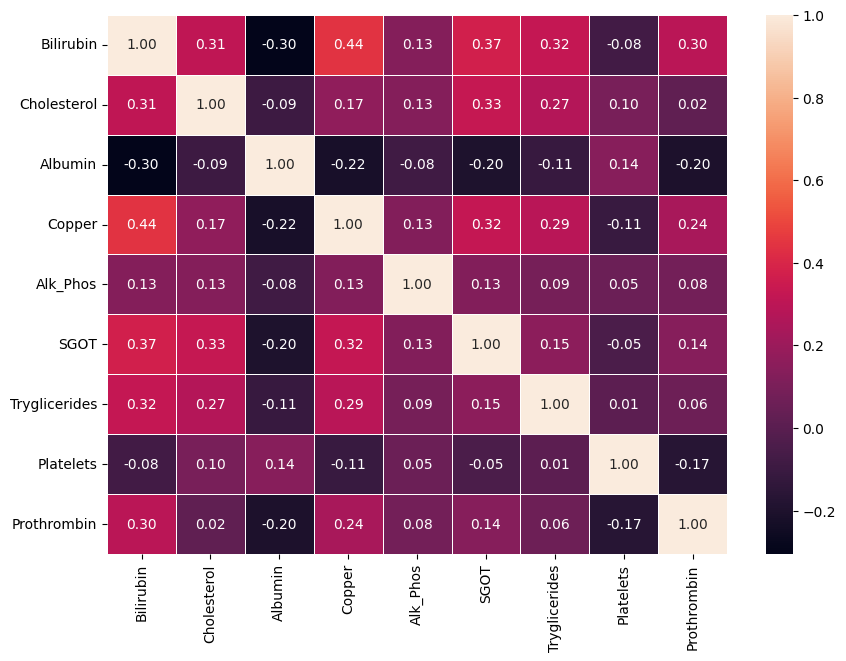

In [11]:
selected_features = [
    
    'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
    'Tryglicerides', 'Platelets', 'Prothrombin'
]

# Create a subset correlation matrix for the selected features
subset_correlation_matrix = train_data[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    subset_correlation_matrix,
    annot=True,
    fmt=".2f",
    linewidths=.5
)

plt.show()

**No noticable high correlation** - no action taken.

### Dropping Missing Values

In [12]:
CAT_FEATS = ["Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]
NUM_FEATS = [x for x in train_data.columns if x not in CAT_FEATS and x != LABEL]

# Copy dataframes and modify them
train_modified = train_data.copy()
test_modified = test_data.copy()

In [13]:
print(train_modified.shape[0])
train_modified = train_modified.dropna()
print(train_modified.shape[0])
test_modified = test_modified.dropna()

8323
8181


### Feature Encoding 

In [14]:
label_encoder = LabelEncoder()
train_modified[LABEL] = label_encoder.fit_transform(train_modified[LABEL]) #Encoding target.

encoders = {
    'Drug': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['Placebo', 'D-penicillamine']]),
    'Sex': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Ascites': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Hepatomegaly': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Spiders': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Edema': OneHotEncoder(),
    'Stage': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
}

**Applying encoding on train_data and test_data:**

In [15]:
for feat, enc in encoders.items():
    if isinstance(enc, OrdinalEncoder):
        train_modified[feat] = enc.fit_transform(train_modified[[feat]]).astype('int32')
        test_modified[feat] = enc.transform(test_modified[[feat]]).astype('int32')
    if isinstance(enc, OneHotEncoder):
        new_cols = enc.fit_transform(train_modified[[feat]]).toarray().astype('int8')
        col_names = enc.get_feature_names_out()
        
        train_modified[col_names] = new_cols
        train_modified.drop(feat, axis=1, inplace=True)
        
        new_cols_test = enc.transform(test_modified[[feat]]).toarray().astype('int8')
        test_modified[col_names] = new_cols_test
        test_modified.drop(feat, axis=1, inplace=True)
train_modified

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,...,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Edema_N,Edema_S,Edema_Y
0,999,1,21532,1,0,0,0,2.3,316.0,3.35,...,1601.0,179.80,63.0,394.0,9.7,2,2,1,0,0
1,2574,0,19237,0,0,0,0,0.9,364.0,3.54,...,1440.0,134.85,88.0,361.0,11.0,2,0,1,0,0
2,3428,0,13727,0,0,1,1,3.3,299.0,3.55,...,1029.0,119.35,50.0,199.0,11.7,3,2,0,0,1
3,2576,0,18460,0,0,0,0,0.6,256.0,3.50,...,1653.0,71.30,96.0,269.0,10.7,2,0,1,0,0
4,788,0,16658,0,0,1,0,1.1,346.0,3.65,...,1181.0,125.55,96.0,298.0,10.6,3,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8212,1153,1,22347,0,0,1,0,0.4,246.0,3.58,...,797.0,91.00,113.0,288.0,10.4,1,0,1,0,0
8213,994,0,21294,0,0,0,0,0.4,260.0,2.75,...,1166.0,70.00,82.0,231.0,10.8,1,0,1,0,0
8214,939,1,22767,0,0,0,0,1.7,434.0,3.35,...,1713.0,171.00,100.0,234.0,10.2,1,0,1,0,0
8215,839,1,13879,0,0,0,0,2.0,247.0,3.16,...,1050.0,117.00,88.0,335.0,10.5,1,0,1,0,0


## Additional Features
This section is copied from [this notebook](https://www.kaggle.com/code/markuslill/s3e26-xgbclassifer) by [MLMOSAIC](https://www.kaggle.com/markuslill) 

We will create some additional features. An explanation is provided below:

| Transformer Class     | Type | Description |
|-----------------------|------|-------------|
| `DiagnosisDateTransformer`   | `num` | Calculates 'Diagnosis_Date' by subtracting 'N_Days' from 'Age'. This could provide a more direct measure of time since diagnosis, relevant for analysis.          |
| `AgeBinsTransformer`         | `cat` | Categorizes 'Age' into bins (19, 29, 49, 64, 99), converting a continuous variable into a categorical one for simplified analysis.                 |
| `BilirubinAlbuminTransformer`| `num` | Creates a new feature 'Bilirubin_Albumin' by multiplying 'Bilirubin' and 'Albumin', potentially highlighting interactions between these two variables.             |
| `NormalizeLabValuesTransformer`| `num` | Normalizes laboratory values (like 'Bilirubin', 'Cholesterol', etc.) to their z-scores, standardizing these features for modeling purposes.                       |
| `DrugEffectivenessTransformer`| `num` | Generates a new feature 'Drug_Effectiveness' by combining 'Drug' and 'Bilirubin' levels. This assumes that changes in 'Bilirubin' reflect drug effectiveness.   |
| `SymptomScore(Cat)Transformer`    | `num` | Summarizes the presence of symptoms ('Ascites', 'Hepatomegaly', etc.) into a single 'Symptom_Score', simplifying the representation of patient symptoms.      |
| `LiverFunctionTransformer`   | `num` | Computes 'Liver_Function_Index' as the average of key liver function tests, providing a comprehensive metric for liver health.                                    |
| `RiskScoreTransformer`       | `num` | Calculates 'Risk_Score' using a combination of 'Bilirubin', 'Albumin', and 'Alk_Phos', potentially offering a composite risk assessment for patients.              |
| `TimeFeaturesTransformer`    | `num` | Extracts 'Year' and 'Month' from 'N_Days', converting a continuous time measure into more interpretable categorical time units.                                    |


### Creating  [MLMOSAIC](https://www.kaggle.com/markuslill)'s features:

In [17]:
class DiagnosisDateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diagnosis_Date'] = X['Age'] - X['N_Days']
        return X
    
class AgeYearsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Years'] = round(X['Age'] / 91.3125).astype("int16")
        X['N_Days'] = round(X['N_Days'] / 3.5).astype("int16")
        return X

class AgeGroupsTransformer(BaseEstimator, TransformerMixin):
    """Older people might be hit harder (interaction) by health issues. Also can cover lifestyle influences, i.e.
    alcohol consumption etc."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Age_Group'] = pd.cut(X['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
        return X

class BilirubinAlbuminTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Bilirubin_Albumin'] = X['Bilirubin'] * X['Albumin']
        return X

class DrugEffectivenessTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Drug_Effectiveness'] = X['Drug'] * X['Bilirubin']
        return X

class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        X['Symptom_Score'] = X[symptom_columns].sum(axis=1)
        return X
    
class SymptomCatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.symptom_columns = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema_N', 'Edema_S', 'Edema_Y']
        self.encoder = OneHotEncoder(handle_unknown='ignore')

    def fit(self, X, y=None):
        X_copy = X.copy()
        symptom_scores = X_copy[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        self.encoder.fit(symptom_scores.values.reshape(-1, 1))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        symptom_scores = X_transformed[self.symptom_columns].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
        encoded_features = self.encoder.transform(symptom_scores.values.reshape(-1, 1)).toarray().astype("int8")
        encoded_feature_names = self.encoder.get_feature_names_out(input_features=['Symptom_Score'])
        X_transformed[encoded_feature_names] = pd.DataFrame(encoded_features, index=X_transformed.index)
        
        return X_transformed


class LiverFunctionTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
        X['Liver_Function_Index'] = X[liver_columns].mean(axis=1)
        return X

class RiskScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Risk_Score'] = X['Bilirubin'] + X['Albumin'] - X['Alk_Phos']
        return X

class TimeFeaturesTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Diag_Year'] = (X['N_Days'] / 365).astype(int)
        X['Diag_Month'] = ((X['N_Days'] % 365) / 30).astype(int)
        return X
    
class ScalingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_feats = NUM_FEATS + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                      'Symptom_Score', 'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.num_feats])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_feats] = self.scaler.transform(X_scaled[self.num_feats])
        return X_scaled

# Define the pipeline
pipeline = Pipeline([
    ('diagnosis_date', DiagnosisDateTransformer()),
    ('age_years', AgeYearsTransformer()),
    ('bilirubin_albumin', BilirubinAlbuminTransformer()),
    ('drug_effectiveness', DrugEffectivenessTransformer()),
    ('symptom_score', SymptomScoreTransformer()),
    ('symptom_cat_score', SymptomCatTransformer()),
    ('liver_function', LiverFunctionTransformer()),
    ('risk_score', RiskScoreTransformer()),
    ('time_features', TimeFeaturesTransformer()),
])

train_modified = pipeline.fit_transform(train_modified)
test_modified = pipeline.transform(test_modified)

CAT_FEATS = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage',
             'Age_Group', 'Symptom_Score'] 

# Outlier Detection

Observations with feature values that are more than **6 standard deviations from the mean are  considered outliers** and we want to **remove** them.

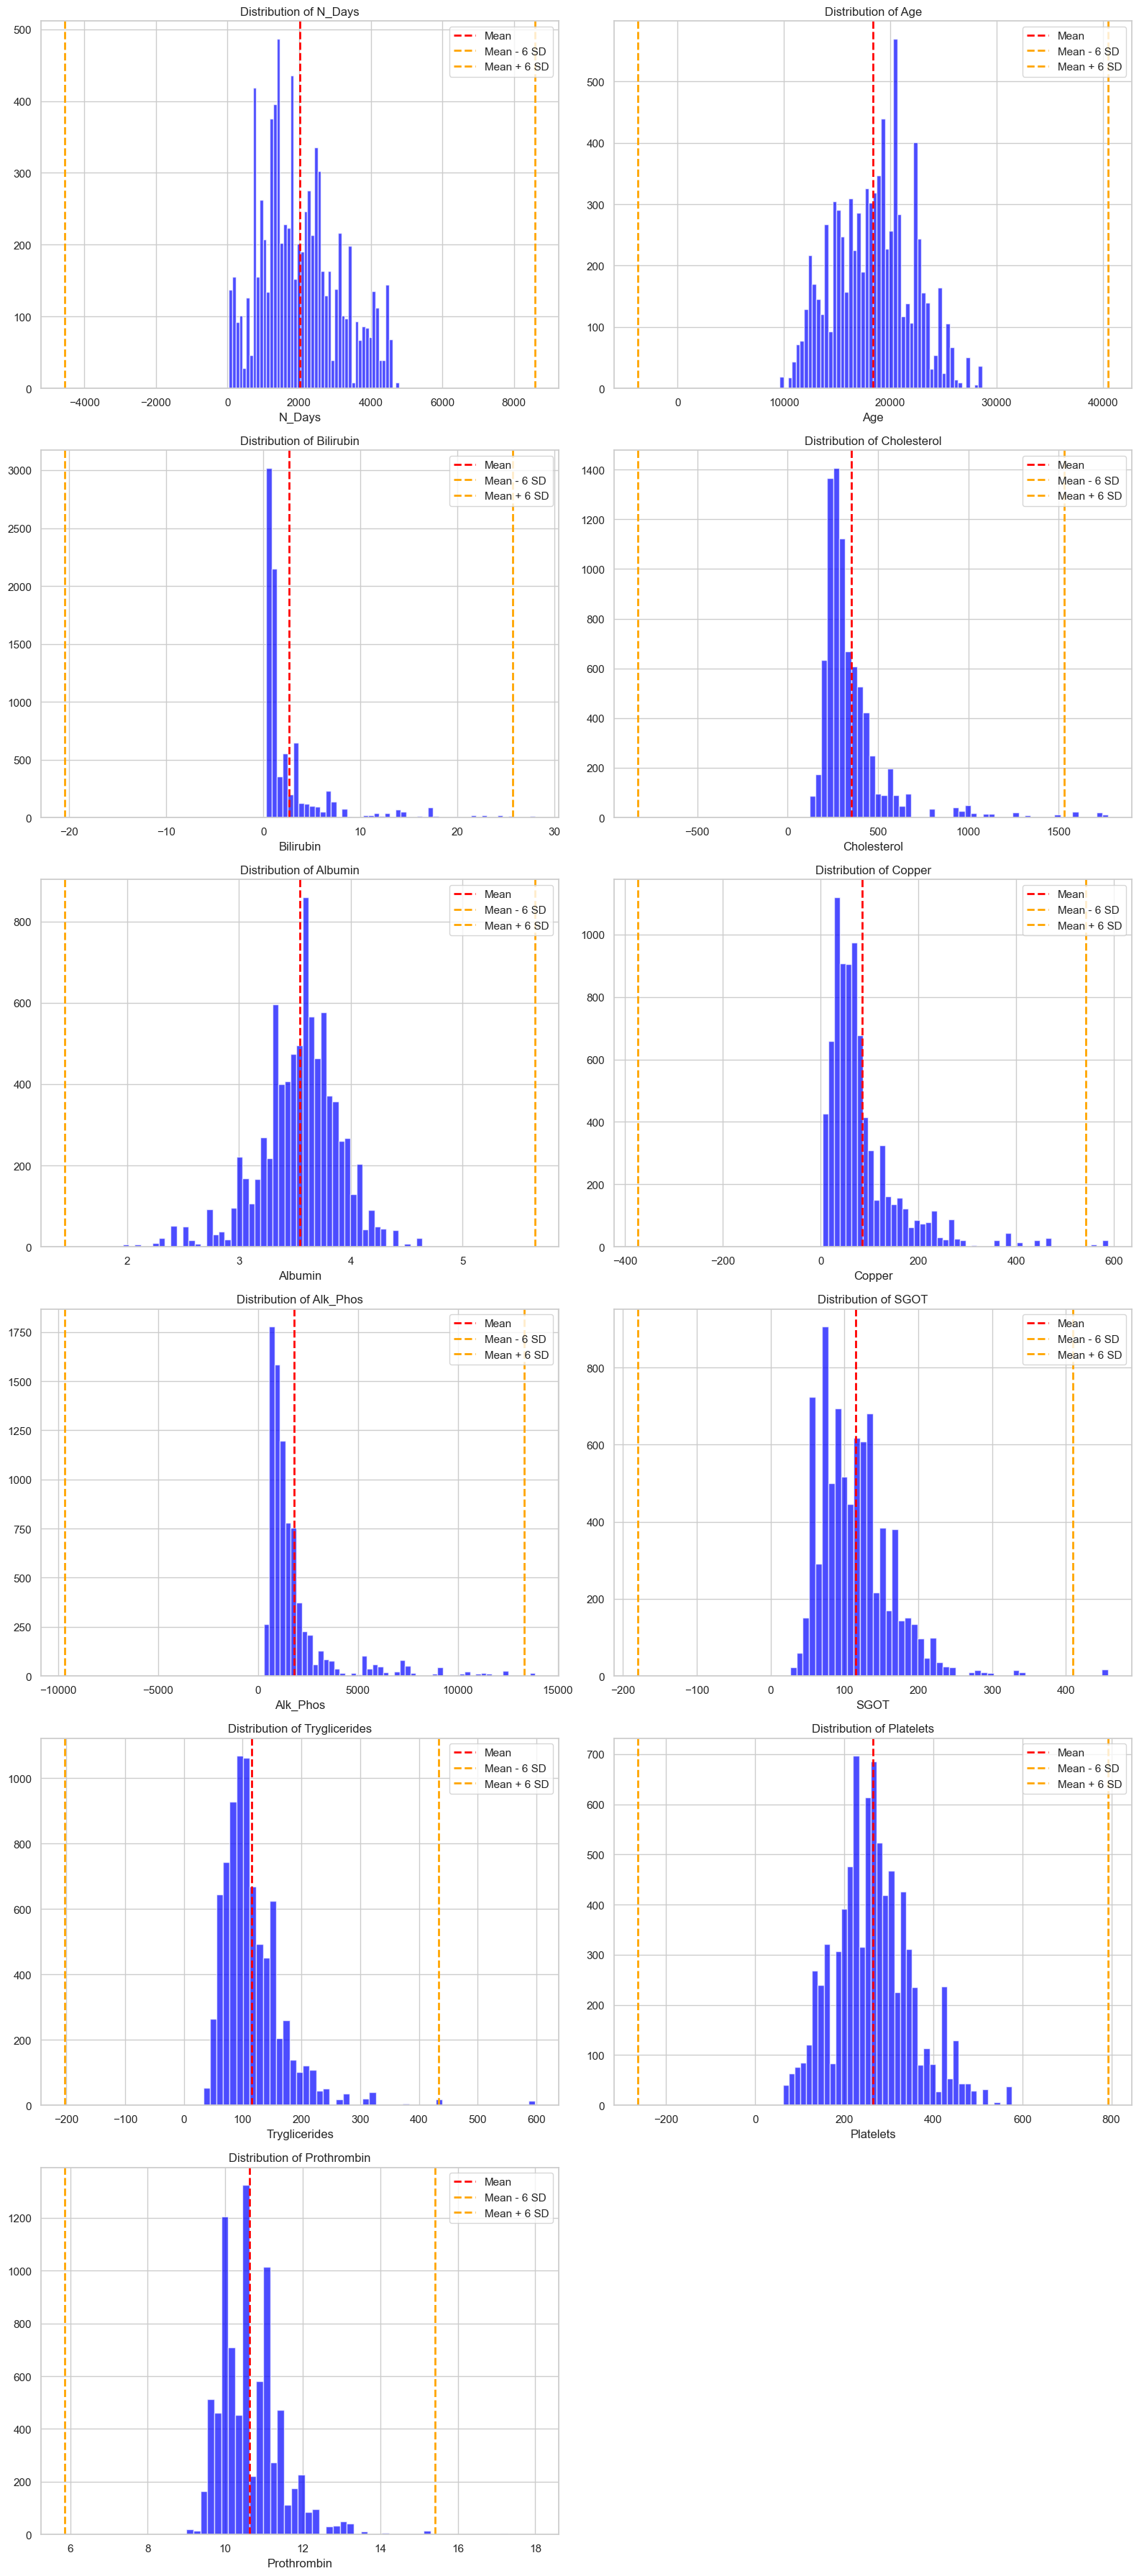

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distributions(data, categorical_columns_to_exclude):
    sns.set(style='whitegrid')  # Add this line to set the seaborn style

    features = [col for col in data.columns if col not in categorical_columns_to_exclude]

    num_features = len(features)
    num_plots_per_line = 2
    num_rows = (num_features + num_plots_per_line - 1) // num_plots_per_line

    fig, axs = plt.subplots(num_rows, num_plots_per_line, figsize=(16, 6 * num_rows))

    for i, feature in enumerate(features):
        row_index = i // num_plots_per_line
        col_index = i % num_plots_per_line

        # Distribution Plot
        axs[row_index, col_index].hist(
            data[feature],
            color='blue',
            bins=50,
            alpha=0.7,
        )
        axs[row_index, col_index].axvline(data[feature].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean')
        axs[row_index, col_index].axvline(data[feature].mean() - 6 * data[feature].std(), color='orange', linestyle='dashed', linewidth=2, label='Mean - 6 SD')
        axs[row_index, col_index].axvline(data[feature].mean() + 6 * data[feature].std(), color='orange', linestyle='dashed', linewidth=2, label='Mean + 6 SD')
        axs[row_index, col_index].set_title(f'Distribution of {feature}')
        axs[row_index, col_index].set_xlabel(feature)
        axs[row_index, col_index].legend()

    # If there are empty subplots, remove them
    for i in range(num_features, num_rows * num_plots_per_line):
        row_index = i // num_plots_per_line
        col_index = i % num_plots_per_line
        fig.delaxes(axs[row_index, col_index])

    plt.tight_layout()
    plt.show()

# Assuming you have a DataFrame named 'train_data'
categorical_columns_to_exclude = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status', 'Stage']
plot_distributions(train_data, categorical_columns_to_exclude)

tmp_df = train_modified.copy()

# Calculate the mean and standard deviation for each column
means = tmp_df[NUM_FEATS].mean()
std_devs = tmp_df[NUM_FEATS].std()

# Define a threshold for what you consider to be an outlier, typically 3 standard deviations from the mean
n_stds = 6
thresholds = n_stds * std_devs

# Detect outliers
outliers = (np.abs(tmp_df[NUM_FEATS] - means) > thresholds).any(axis=1)

In [19]:
print(f"Detected {sum(outliers)} that are more than {n_stds} SDs away from mean...")

Detected 147 that are more than 6 SDs away from mean...


## Outlier Removal:

In [20]:
outliers_df = tmp_df[outliers]
print(f"Train data shape BEFORE outlier removal: {train_modified.shape}")
train_modified = tmp_df[~outliers].reset_index(drop=True)
print()
print(f"Train data shape AFTER outlier removal: {train_modified.shape}")

Train data shape BEFORE outlier removal: (8181, 54)

Train data shape AFTER outlier removal: (8034, 54)


# Feature Engineering - My Approach

**Looking at the normal ranges mentioned earlier** and the earlier description of the data you can conclude **not everyone falls within** the normal range. Typical or normal range refers to healthy people; **the subjects in the dataset** had been diagnosed with liver disease of various stages and **were not healthy people**.

The following is a **pie chart** for each of the mentioned features **indicating how many people fall within the normal range**. 

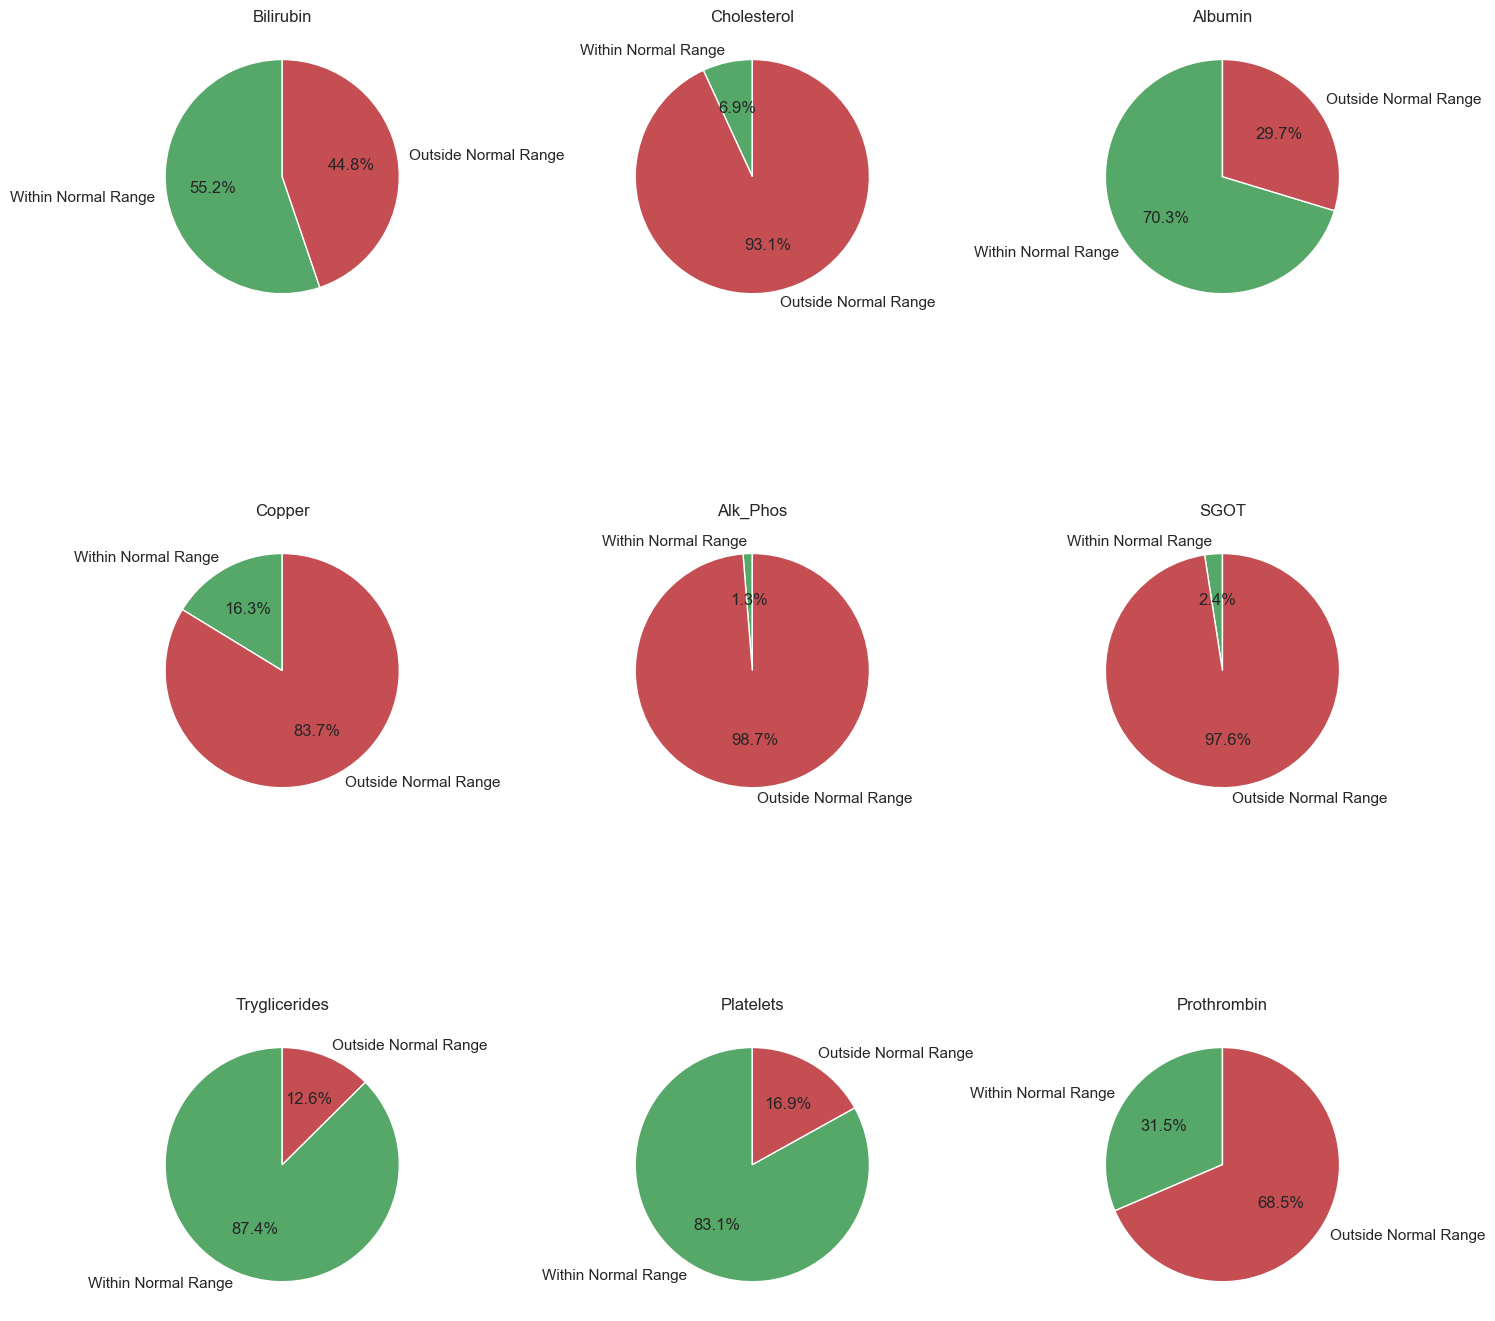

In [21]:
normal_ranges = { #As mentioned in the earlier section.
    'Bilirubin': (0.1, 1.2),
    'Cholesterol': (125, 200),
    'Albumin': (3.4, 5.4),
    'Copper': (10, 30),
    'Alk_Phos': (40, 129),
    'SGOT': (8, 45),
    'Tryglicerides': (48.68, 168.15),
    'Platelets': (150, 400),
    'Prothrombin': (11,13.5)
}
df_adding_features = train_data.copy()

for feature, (normal_range_min, normal_range_max) in normal_ranges.items():
    df_adding_features[f'{feature}_is_normal'] = (df_adding_features[feature] >= normal_range_min) & (df_adding_features[feature] <= normal_range_max)
    df_adding_features.loc[~df_adding_features[f'{feature}_is_normal'], f'{feature}_deviation'] = abs(df_adding_features[feature] - ((normal_range_min + normal_range_max) / 2))

df_adding_features.fillna(0, inplace=True)

df_for_pie=df_adding_features.copy()
numerical_features = ['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
df_for_pie = df_for_pie[numerical_features + [col for col in df_for_pie.columns if 'deviation' in col]]

def create_pie_chart(ax, feature):
    within_normal_range = df_for_pie[f'{feature}_deviation'].eq(0).sum()
    outside_normal_range = len(df_for_pie) - within_normal_range

    sns.set(style="whitegrid")
    ax.pie([within_normal_range, outside_normal_range], labels=['Within Normal Range', 'Outside Normal Range'], autopct='%1.1f%%', startangle=90, colors=['#55a868', '#c44e52'])
    ax.set_title(f'{feature}')

num_plots = len(numerical_features)
num_per_line = 3
num_lines = -(-num_plots // num_per_line) 

fig, axes = plt.subplots(num_lines, num_per_line, figsize=(15, 5 * num_lines))  

axes = axes.flatten() if num_lines == 1 else axes

for i, feature in enumerate(numerical_features):
    create_pie_chart(axes[i // num_per_line, i % num_per_line], feature)

for j in range(num_plots, num_lines * num_per_line):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

**My Approach is adding 18 more features to the dataset.**

**9 Is_normal Features** indicating whether or not this row/patient **falls within the noraml range** for the feature being inspected **or not (True/False)**

**9 Deviation Features**, when is_normal is **False** (indicating instance is **outside normal range**), **distance/deviation** from the normal range **is calculated**.

**Defining normal ranges:**

In [22]:
normal_ranges = { #As mentioned in the earlier section.
    'Bilirubin': (0.1, 1.2),
    'Cholesterol': (125, 200),
    'Albumin': (3.4, 5.4),
    'Copper': (10, 30),
    'Alk_Phos': (40, 129),
    'SGOT': (8, 45),
    'Tryglicerides': (48.68, 168.15),
    'Platelets': (150, 400),
    'Prothrombin': (11,13.5)
}

**Calculating Deviation features** and **creating '_is_normal' features**. 

The initial pie charts illustrate the distribution of patients **within and outside the normal range** without specifying **whether it's below or above!** It's crucial to recognize that medically, not all features pose a risk when just outside the normal range. For instance, **Albumin** poses a risk when **below the normal range**, while **Bilirubin** is risky when **above the normal range**. 

Therefore, adopting a **binary approach** (within/outside normal range) for all features **may not be suitable**. Instead, we should categorize them as **above** (for most features), **below** (for Albumin), or **both** (for Platelets).

And that is done in the following cell:

In [23]:
for feature, (normal_range_min, normal_range_max) in normal_ranges.items():
    if feature == 'Platelets':
        train_modified[f'{feature}_is_normal'] = (train_modified[feature] >= normal_range_min) & (train_modified[feature] <= normal_range_max)
    elif feature == 'Albumin':
        train_modified[f'{feature}_is_normal'] = (train_modified[feature] >= normal_range_min)
    else:
        train_modified[f'{feature}_is_normal'] = (train_modified[feature] <= normal_range_max)

    # Add deviation calculation as before
    train_modified.loc[~train_modified[f'{feature}_is_normal'], f'{feature}_deviation'] = train_modified[feature] - ((normal_range_min + normal_range_max) / 2)

train_modified.fillna(0, inplace=True)
train_modified

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,...,Alk_Phos_is_normal,Alk_Phos_deviation,SGOT_is_normal,SGOT_deviation,Tryglicerides_is_normal,Tryglicerides_deviation,Platelets_is_normal,Platelets_deviation,Prothrombin_is_normal,Prothrombin_deviation
0,285,1,21532,1,0,0,0,2.3,316.0,3.35,...,False,1516.5,False,153.30,True,0.0,True,0.0,True,0.0
1,735,0,19237,0,0,0,0,0.9,364.0,3.54,...,False,1355.5,False,108.35,True,0.0,True,0.0,True,0.0
2,979,0,13727,0,0,1,1,3.3,299.0,3.55,...,False,944.5,False,92.85,True,0.0,True,0.0,True,0.0
3,736,0,18460,0,0,0,0,0.6,256.0,3.50,...,False,1568.5,False,44.80,True,0.0,True,0.0,True,0.0
4,225,0,16658,0,0,1,0,1.1,346.0,3.65,...,False,1096.5,False,99.05,True,0.0,True,0.0,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8029,329,1,22347,0,0,1,0,0.4,246.0,3.58,...,False,712.5,False,64.50,True,0.0,True,0.0,True,0.0
8030,284,0,21294,0,0,0,0,0.4,260.0,2.75,...,False,1081.5,False,43.50,True,0.0,True,0.0,True,0.0
8031,268,1,22767,0,0,0,0,1.7,434.0,3.35,...,False,1628.5,False,144.50,True,0.0,True,0.0,True,0.0
8032,240,1,13879,0,0,0,0,2.0,247.0,3.16,...,False,965.5,False,90.50,True,0.0,True,0.0,True,0.0


**Question:** What is this line for? 


**train_modified.fillna(0, inplace=True)**

**train_modified**


**Answer:** When the values are initially in the normal range, there won't be any calculated deviation for their respective deviation columns, **resulting in them containing NaN**. 

To handle these NaN values i **replace them with zeros**. 

So **the final shape of deviation columns** will contain one of 3 values: 
1. **Negative deviation** (values originally below normal range)
2. **Positive deviation** (values originally above normal range)
3. **Zero deviation** (values originally within normal range).

**Creating the features for test_data as well**

In [24]:
for feature, (normal_range_min, normal_range_max) in normal_ranges.items():
    if feature == 'Platelets':
        test_modified[f'{feature}_is_normal'] = (test_modified[feature] >= normal_range_min) & (test_modified[feature] <= normal_range_max)
    elif feature == 'Albumin':
        test_modified[f'{feature}_is_normal'] = (test_modified[feature] >= normal_range_min)
    else:
        test_modified[f'{feature}_is_normal'] = (test_modified[feature] <= normal_range_max)

    # Add deviation calculation as before
    test_modified.loc[~test_modified[f'{feature}_is_normal'], f'{feature}_deviation'] = test_modified[feature] - ((normal_range_min + normal_range_max) / 2)

test_modified.fillna(0, inplace=True)
test_modified

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,...,Alk_Phos_is_normal,Alk_Phos_deviation,SGOT_is_normal,SGOT_deviation,Tryglicerides_is_normal,Tryglicerides_deviation,Platelets_is_normal,Platelets_deviation,Prothrombin_is_normal,Prothrombin_deviation
0,7905,1097,1,19724,0,0,1,0,1.2,546.0,...,False,1551.5,False,125.40,True,0.0,False,155.0,True,0.00
1,7906,705,1,14975,0,0,0,0,1.1,660.0,...,False,1172.5,False,125.40,True,0.0,True,0.0,True,0.00
2,7907,15,0,13149,0,0,1,0,2.0,151.0,...,False,876.5,False,43.25,True,0.0,True,0.0,True,0.00
3,7908,666,1,20510,0,0,0,0,0.6,293.0,...,False,469.5,False,99.05,True,0.0,True,0.0,True,0.00
4,7909,461,1,21904,0,0,1,0,1.4,277.0,...,False,1025.5,False,98.50,True,0.0,True,0.0,True,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13171,820,0,12279,0,0,0,0,1.3,302.0,...,False,1260.5,False,118.50,True,0.0,True,0.0,True,0.00
5267,13172,506,0,24803,0,0,0,0,0.5,219.0,...,False,578.5,False,52.55,True,0.0,True,0.0,True,0.00
5268,13173,1059,1,16990,0,0,1,0,0.8,315.0,...,False,1552.5,False,144.00,True,0.0,False,151.0,True,0.00
5269,13174,347,0,11773,0,0,0,0,0.7,329.0,...,False,593.5,False,30.50,True,0.0,True,0.0,True,0.00


Before delving into the next parameter tuning section, **let me illustrate a proof of concept** concerning the idea that certain features present a greater risk when below the normal range, and vice versa when above it.

In the upcoming pie charts, I showcase **the percentage of individuals with a 'Status' of 'D'** (deceased), **distinguishing between those with readings above and below the normal range**.

You'll notice a distinct pattern with **Albumin**—every individual who passed away had Albumin levels **below the normal range**. In contrast, for most other features, the readings were predominantly above the normal range.

# Adding 3 New features 
## from a [research paper](https://karger.com/ddi/article/41/6/946/845237/The-Albumin-Bilirubin-Score-as-a-Predictor-of) proposing a new feature using Albumin-Bilirubin.
Shared by [Meagan](https://www.kaggle.com/mvoulo) in this [discussion](https://www.kaggle.com/competitions/playground-series-s3e26/discussion/463072)

![image.png](attachment:01779ad2-136a-4ccb-95dd-dec3f37787fa.png)

----------------------------------------------------------------------------------------------------
The paper highlighted various pertinent **features** employed as **predictors of liver-related mortality**, including the **Mayo score**.

The code will utilize the **equations presented in Table 1** to calculate and incorporate **Mayo risk score and ALBI**.

![image.png](attachment:3acf3170-647b-4f1a-8d96-dff0c9549236.png)

**ALBI**

In [26]:
train_modified['ALBI'] = 0.66 * np.log10(train_modified['Bilirubin'] * 17.104) - 0.085 * train_modified['Albumin'] * 10 
test_modified['ALBI'] = 0.66 * np.log10(test_modified['Bilirubin'] * 17.104) - 0.085 * test_modified['Albumin'] * 10 

Regarding **ALBI**, the research paper specifies that **patients were classified into three groups** based on their **ALBI values**, as illustrated in the image below. Therefore, I will include **ALBI_status** in the analysis.

---------
![image.png](attachment:e4fc3e6c-4f84-4afe-b382-7b509e90ad4e.png)

---------

In [27]:
def assign_albi_status(data):
    data['ALBI_status'] = 0
    
    conditions = [
        (data['ALBI'] <= -2.60),
        ((data['ALBI'] > -2.60) & (data['ALBI'] <= 1.39)),
        (data['ALBI'] > 1.39)
    ]
    
    values = [1, 2, 3]
    data['ALBI_status'] = np.select(conditions, values, default=0)

assign_albi_status(train_modified)
assign_albi_status(test_modified)

# Applying PCA 

In earlier versions, **I selected approximately 30 features out of the total 72 for training.** 

[MLmosaic](https://www.kaggle.com/markuslill) proposed an effective strategy to use the remaining features into a **Principal Component Analysis (PCA)**. 

Following several trials, I determined the optimal features for PCA consolidation and those to retain for training purposes.

**Mayo risk score and ALBI were put into the PCA**, while **ALBI_status was retained for direct training** purposes

In [28]:
#The following features will not be in the PCA
exclude_features = ['Platelets', 'Copper','Alk_Phos','Diagnosis_Date','SGOT','Age_Years','N_Days','Cholesterol', 
         'Tryglicerides','Albumin','Bilirubin','Prothrombin','Symptom_Score','Stage','Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y','Status','ALBI_status']

np.random.seed(42)

included_features = [col for col in train_modified.columns if col not in exclude_features]

X = train_modified[included_features]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(n_components=1)
train_modified['PCA_0'] = pca.fit_transform(X_standardized)

print(f"Variance explained by PCA_0: {pca.explained_variance_ratio_[0]:.2%}")

Variance explained by PCA_0: 11.87%


**Applying PCA on test_data**

In [29]:
exclude_features = ['Platelets', 'Copper','Alk_Phos','Diagnosis_Date','SGOT','Age_Years','N_Days','Cholesterol', 
         'Tryglicerides','Albumin','Bilirubin','Prothrombin','Symptom_Score','Stage','Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y','Status','ALBI_status']
np.random.seed(42)

included_features = [col for col in test_modified.columns if col not in exclude_features]

X = test_modified[included_features]

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(n_components=1)
test_modified['PCA_0'] = pca.fit_transform(X_standardized)

print(f"Variance explained by PCA_0: {pca.explained_variance_ratio_[0]:.2%}")

Variance explained by PCA_0: 12.01%


# Hyperparameters Tuning

**XGBClassifier's optuna (overpowered tuna 💪🐟) search to find best hyper-parameter**


In [33]:
# from xgboost import XGBClassifier

# number_of_trials = 2000

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# def objective_xgb(trial):
#     xgb_params = {
#     'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
#     'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
#     'max_depth': trial.suggest_int('max_depth', 2, 15),
#     'eta': trial.suggest_float('eta', 0.001, 0.1, log=True),
#     'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#     'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#     'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#     'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
#     'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
#     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#     'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#     'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
# }

#     model_xgb = XGBClassifier(**xgb_params, n_jobs=-1)

#     cv_scores = []
#     for train_idx, val_idx in skf.split(X_train, Y_train):
#         X_tr, X_va = X_train[train_idx], X_train[val_idx]
#         Y_tr, Y_va = Y_train[train_idx], Y_train[val_idx]

#         eval_set = [(X_va, Y_va)]
#         model_xgb.fit(X_tr, Y_tr, eval_set=eval_set, verbose=0)

#         y_val_pred_xgb = model_xgb.predict_proba(X_va)
#         fold_score = log_loss(Y_va, y_val_pred_xgb)
#         cv_scores.append(fold_score)

#     return np.mean(cv_scores)

# study_xgb = optuna.create_study(direction='minimize')

# study_xgb.optimize(objective_xgb, n_trials=number_of_trials)

##plotting the history of searching:

# fig, ax = plt.subplots()
# history = study_xgb.trials_dataframe()
# ax.plot(history['value'], label='Objective Value')
# ax.set_xlabel('Iteration')
# ax.set_ylabel('Objective Value')
# ax.set_title('Optimization History')
# ax.legend()
# plt.show()

**Best Paramters:**

{'lambda': 1.1369029459700144e-06, 'alpha': 0.012063715109367643, 'max_depth': 6, 'eta': 0.0016842485569386354, 'gamma': 1.8110005586084708e-08, 'colsample_bytree': 0.14198953405080517, 'subsample': 0.7387879239640978, 'min_child_weight': 1, 'n_estimators': 931, 'learning_rate': 0.07244128492444549, 'reg_alpha': 0.7206512712096103, 'reg_lambda': 0.33555254247327354}


In [34]:
xgb_params = {'lambda': 1.1369029459700144e-06, 'alpha': 0.012063715109367643, 'max_depth': 6, 'eta': 0.0016842485569386354, 'gamma': 1.8110005586084708e-08, 'colsample_bytree': 0.14198953405080517, 'subsample': 0.7387879239640978, 'min_child_weight': 1, 'n_estimators': 931, 'learning_rate': 0.07244128492444549, 'reg_alpha': 0.7206512712096103, 'reg_lambda': 0.33555254247327354}

**Saving results so far.**

In [36]:
train_modified.to_csv('Multi-Class Prediction of Cirrhosis Outcome/train_data.csv', index=False)
test_modified.to_csv('Multi-Class Prediction of Cirrhosis Outcome/test_data.csv', index=False)

# Model training and Evaluation

In [37]:
FEATS = ['Platelets', 'Copper','Alk_Phos','Diagnosis_Date','SGOT','Age_Years','N_Days','Cholesterol', 
         'Tryglicerides','Albumin','Bilirubin','Prothrombin','Symptom_Score','Stage','Drug', 
         'Hepatomegaly', 'Spiders', 'Sex', 'Edema_N', 'Edema_S', 'Edema_Y','ALBI_status','PCA_0']
print(f"Number of feats: {len(FEATS)}")

Number of feats: 23


In [38]:
train_final = train_modified[FEATS + [LABEL]]
test_final = test_modified[FEATS]

**Validation function:**

In [39]:
def validate_models(models: list[dict],
                    data: pd.DataFrame, 
                    label=LABEL,
                    n_splits=5,
                    n_repeats=1,
                    seed=43):
    train_scores, val_scores = {}, {}
    
    pbar = tqdm(models)
    for model in pbar:
        model_str = model["name"]
        model_est = model["model"]
        model_feats = model["feats"]
        
        pbar.set_description(f"Processing {model_str}...")
        
        train_scores[model_str] = []
        val_scores[model_str] = []
        skf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)

        for i, (train_idx, val_idx) in enumerate(skf.split(data[model_feats], data[label])):
            pbar.set_postfix_str(f"Fold {i+1}/{n_splits}")
            
            X_train, y_train = data[model_feats].loc[train_idx], data[label].loc[train_idx]
            X_val, y_val = data[model_feats].loc[val_idx], data[label].loc[val_idx]
            
            if model_str in ["lgb_cl"]:
                callbacks = [lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)
            elif model_str in ["xgb_cl", "cat_cl"]:
                model_est.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
            elif model_str in ["voting_clf"]:
                pass # TODO: find a solution
            else:
                model_est.fit(X_train, y_train)
                
            train_preds = model_est.predict_proba(X_train[model_feats])
            valid_preds = model_est.predict_proba(X_val[model_feats])
            train_score = log_loss(y_train, train_preds)
            val_score = log_loss(y_val, valid_preds)
            train_scores[model_str].append(train_score)
            val_scores[model_str].append(val_score)
            
            #print(f"{model_str} | Fold {i + 1} | " +
            #      f"Train log_loss: {round(train_score, 4)} | " +
            #      f"Valid log_loss: {round(val_score, 4)}")
        
        model["avg_val_score"] = np.mean(val_scores[model_str])
            
    return models, pd.DataFrame(train_scores), pd.DataFrame(val_scores)

In [40]:
%%time
xgb_cl = xgb.XGBClassifier(**xgb_params)
models = [
    {"name": "xgb_cl", "model": xgb_cl, "feats": FEATS},
]
models, train_scores, val_scores = validate_models(models=models, 
                                                   data=train_final, 
                                                   n_splits=10,
                                                   n_repeats=1)

Processing xgb_cl...: 100%|██████████| 1/1 [00:51<00:00, 51.63s/it, Fold 10/10]

CPU times: total: 5min 46s
Wall time: 51.6 s


**Inspecting the performances on the train and validation sets:**

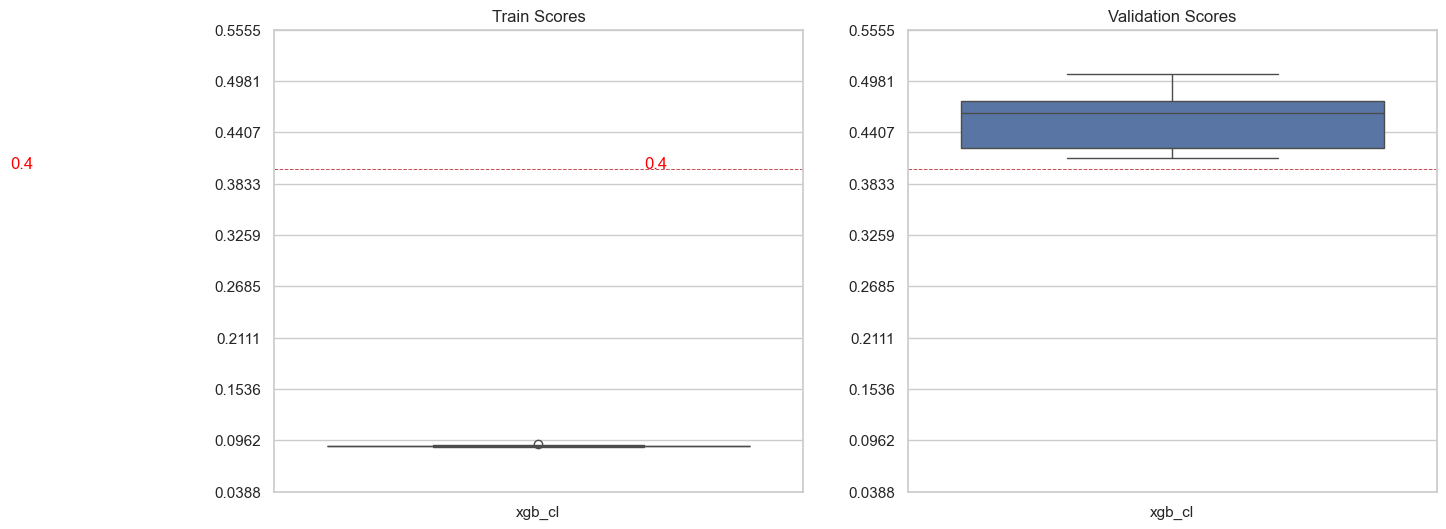

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

eps = .05
hl = .4
min_score = train_scores.min().min()-eps
max_score = val_scores.max().max()+eps

def calculate_ticks(min_score, max_score, num_ticks=10):
    return np.linspace(min_score, max_score, num_ticks)

ticks = calculate_ticks(min_score, max_score)

_ = sns.boxplot(train_scores, ax=axes[0])
_ = axes[0].set_title('Train Scores')
_ = axes[0].set_ylim(min_score, max_score)
_ = axes[0].set_yticks(ticks)
_ = axes[0].yaxis.grid(True)
_ = axes[0].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[0].text(-1, hl, f"{hl}", c="red")

_ = sns.boxplot(val_scores, ax=axes[1])
_ = axes[1].set_title('Validation Scores')
_ = axes[1].set_ylim(min_score, max_score)
_ = axes[1].set_yticks(ticks)
_ = axes[1].yaxis.grid(True)
_ = axes[1].axhline(y=0.4, color='r', linestyle='--', lw=.7)
_ = axes[1].text(-1, hl, f"{hl}", c="red")

           Train  Validation
count  10.000000   10.000000
mean    0.090023    0.454490
std     0.000966    0.031859
min     0.088830    0.412132
25%     0.089514    0.422618
50%     0.089685    0.462360
75%     0.090324    0.476256
max     0.092159    0.505493


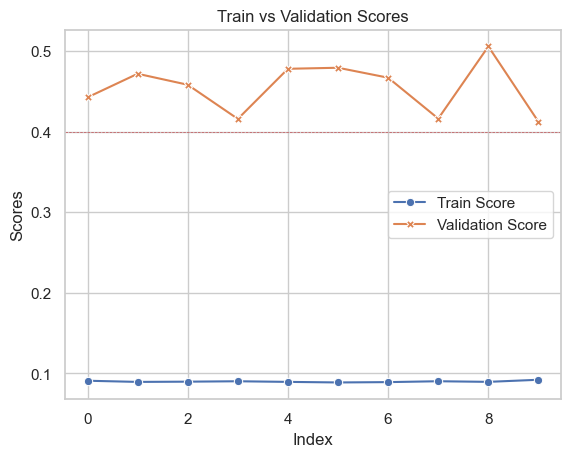

In [42]:
# Print results in DataFrame
model_res = pd.concat([train_scores.describe(), val_scores.describe()], axis=1)
model_res.columns = ['Train', 'Validation']
print(model_res)

# Plot results as lineplot
_ = sns.lineplot(pd.concat([train_scores, val_scores], keys=["Train Score", "Validation Score"], axis=1), markers=True, dashes=False)
plt.axhline(y=0.4, color='r', linestyle='--', lw=.5)
plt.title('Train vs Validation Scores')
plt.xlabel('Index')
plt.ylabel('Scores')
plt.show()

In [43]:
class MyAvgVoting(BaseEstimator, ClassifierMixin):
    """A basic voting method that just averages all estimator predictions and 
    predicts the class with the highest vote."""
    def __init__(self, estimators, weighted=False):
        self.estimators = estimators
        # Whether to average according to validation scores
        self.weighted = weighted

    def fit(self, X, y):
        for _, est in self.estimators:
            est["model"].fit(X, y)
        return self
    
    def create_avg_prob_predictions(self, X):
        predictions = np.array([est["model"].predict_proba(X) for est in self.estimators])
        if self.weighted:
            # Note: we need the inverse of the val_score since lower values are "better"
            weights = [{"name": est["name"], "value": 1/est["avg_val_score"]} for est in self.estimators]
            print(f"Weights are:\n{pd.DataFrame(weights)}")
            return np.average(predictions, axis=0, weights=[w["value"] for w in weights])
        return np.average(predictions, axis=0)
            
    def predict(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return np.argmax(avg_predictions, axis=1)

    def predict_proba(self, X):
        avg_predictions = self.create_avg_prob_predictions(X)
        return avg_predictions

    def score(self, X, y):
        pass

voting_ests = models
voting_clf = MyAvgVoting(voting_ests, weighted=False) 
# no fitting needed

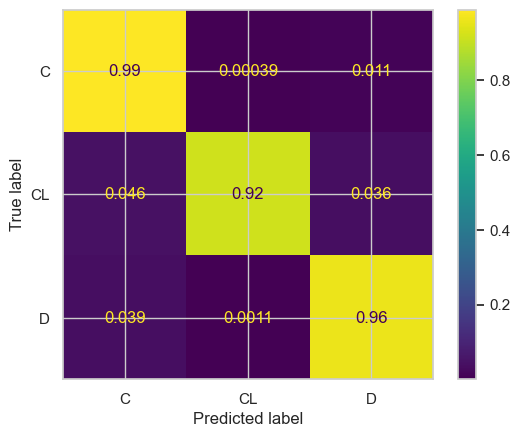

In [44]:
y_hat = xgb_cl.predict(train_final[FEATS])
ConfusionMatrixDisplay.from_predictions(train_final[LABEL], y_hat, normalize='true', display_labels=label_encoder.classes_)
plt.show()

# Feature Importance

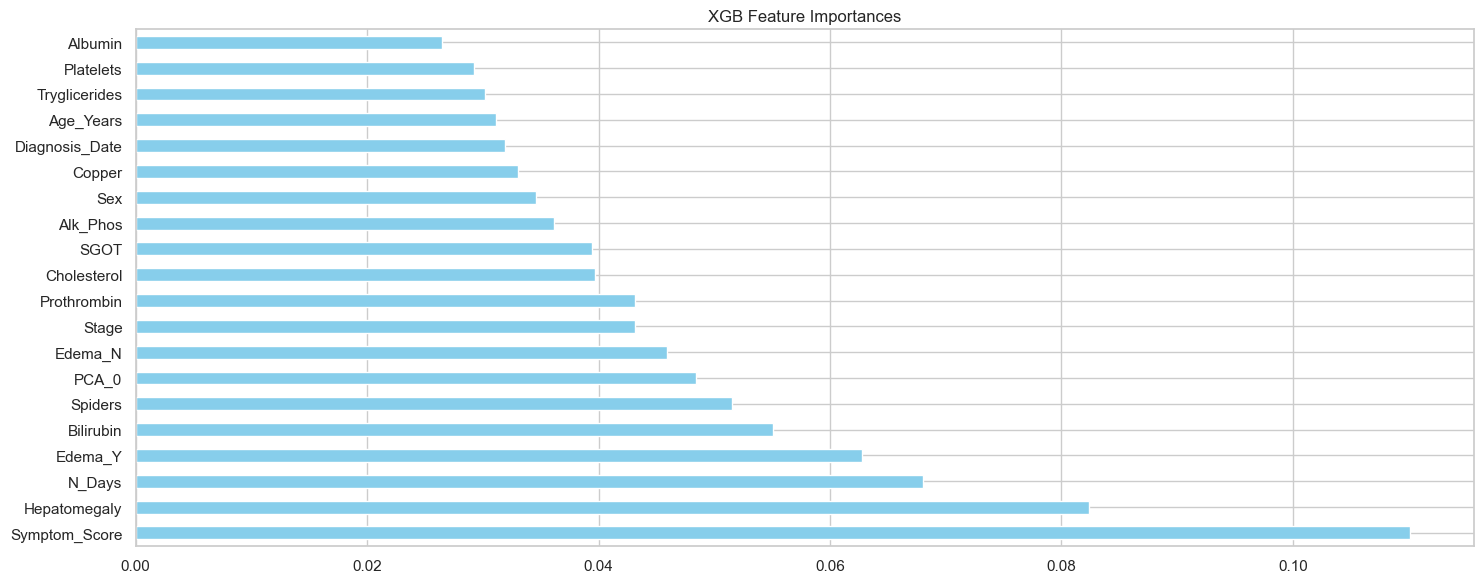

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style (you can choose from "whitegrid", "darkgrid", "white", "dark", "ticks", or customize further)
sns.set(style="whitegrid")

# Creating Pandas Series for feature importances
xgb_feat_importances = pd.Series(xgb_cl.feature_importances_, index=train_final[FEATS].columns)

# Plotting both feature importances in subplots
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

# Customize the appearance of the plot (e.g., change the color)
xgb_feat_importances.nlargest(20).plot(kind='barh', title='XGB Feature Importances', color='skyblue')

plt.tight_layout()
plt.show()

# Submission Ensemble

In [46]:
y_test_hat = xgb_cl.predict_proba(test_final[FEATS])
assert y_test_hat.shape == (test_data.shape[0], 3)

In [47]:
submission_labels = ["Status_C", "Status_CL", "Status_D"]

sub = pd.DataFrame(
    {"id": test_IDs, **dict(zip(submission_labels, y_test_hat.T))}
)
sub.head()

,id,Status_C,Status_CL,Status_D
0,7905,0.377604,0.002498,0.619899
1,7906,0.495332,0.149708,0.354960
2,7907,0.015075,0.001880,0.983044
3,7908,0.976448,0.001624,0.021928
4,7909,0.978682,0.008983,0.012335


**I combine my predicitons with results from other notebooks.**
* [PS3E26 | Cirrhosis Survial Prediction | Multiclass](https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass) by [MASTER JIRAIYA](https://www.kaggle.com/arunklenin)
* [PS3E25 - 🦠 Cirrhosis Multi-Class Solution](https://www.kaggle.com/code/dreygaen/ps3e25-cirrhosis-multi-class-solution) by [LUCAS ANTOINE](https://www.kaggle.com/dreygaen)
* [🛑Multi-Class 📈Prediction of 🦧Cirrhosis Outcomes](https://www.kaggle.com/code/satyaprakashshukl/multi-class-prediction-of-cirrhosis-outcomes) by [SATYA](https://www.kaggle.com/satyaprakashshukl)
* [S3E26 | XGBClassifer](https://www.kaggle.com/code/markuslill/s3e26-xgbclassifer) by [MLMosaic](https://www.kaggle.com/markuslill)

In [52]:
# import os
# from kaggle.api.kaggle_api_extended import KaggleApi

# # Set the Kaggle API key
# api = KaggleApi()
# api_key_path = os.path.join(os.path.expanduser("~"), ".kaggle", "kaggle.json")
# api.authenticate(api_key='8731ebebb339cf786b0ab37b8ea8d1c3', path=api_key_path)

# # Download a dataset (replace 'dataset-name' with the actual dataset name)
# api.dataset_download_files('ensemble/jiraya.csv', path='./Multi-Class Prediction of Cirrhosis Outcome', unzip=True)


In [55]:
# Reading other DataFrames
sub_list = [
    sub
]

# Calculate the mean across all DataFrames
sub_ensemble = pd.concat(sub_list).groupby('id')[submission_labels].mean()

# Normalizing the columns to sum to 1
sub_ensemble[submission_labels] = sub_ensemble[submission_labels].div(sub_ensemble[submission_labels].sum(axis=1), axis=0).fillna(0)
sub_ensemble = sub_ensemble.reset_index()

# Saving and displaying the result
sub_ensemble.to_csv('Multi-Class Prediction of Cirrhosis Outcome/submission.csv', index=False)
sub_ensemble.head(5)

,id,Status_C,Status_CL,Status_D
0,7905,0.377604,0.002498,0.619899
1,7906,0.495332,0.149708,0.354960
2,7907,0.015075,0.001880,0.983044
3,7908,0.976448,0.001624,0.021928
4,7909,0.978682,0.008983,0.012335
